# Comparisons of parameters for different initilizations: same order and couplings to 1

## Classes and functions

In [1]:
from __future__ import print_function, division
import time
import torch
import pickle
from tqdm.notebook import tqdm
from IPython.utils import io
import torch.nn as nn
from torch.nn import Parameter
import LocalEnergyVct as le
import numpy as np
from torch.utils.data import DataLoader, random_split
from data_classes import RNASeqDataset, LocalEnergyOpt
from sklearn.metrics import r2_score
# from my_script import get_target, loss_fn, train, test
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
def get_target(X):
    if len(X['features'].shape) == 2:
        X['features'] = X['features'].unsqueeze(0)
    target = (X['features'][:,0:3,9]).sum(dim=0).squeeze() / X['features'].shape[0]
    return target

# Functions without gradients in the loss

def loss_fn(energy,target):
    # batch_size = energy.shape[0]
    loss = (energy - target).pow(2).sum()  # / batch_size
    return loss


def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    y_true = torch.zeros((num_batches,3))
    y_pred = torch.zeros((num_batches,3))
    for i,X in enumerate(dataloader):
        pred = model(X)
        target = get_target(X)
        y_true[i] = target.reshape(-1,)  # requires drop_last = True
        y_pred[i] = pred.reshape(-1,)
        loss = loss_fn(pred, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    acc = r2_score(y_true,y_pred)
    train_loss /= num_batches
    print(f'Avg loss = {train_loss:>0.4f}, batches = {num_batches}')
    return train_loss, acc


def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    y_true = torch.zeros((num_batches,3))
    y_pred = torch.zeros((num_batches,3))
    with torch.no_grad():
        for i,X in enumerate(dataloader):
            pred = model(X)
            target = get_target(X)
            y_true[i] = target.reshape(-1,) # requires drop_last = True
            y_pred[i] = pred.reshape(-1,)
            loss = loss_fn(pred, target)
            test_loss += loss.item()
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    acc = r2_score(y_true,y_pred)
    test_loss /= num_batches
    print(f'Avg test_loss = {test_loss:>0.4f}, batches = {num_batches}')
    return test_loss, acc


def plot_hist(idx_dict,energies):
    fig,ax = plt.subplots(1,3,figsize=(18,5))
    for i in idx_dict.keys():
        hist1 = ax[i].hist(energies['amber'][i], bins=30, density=True, label='Amber')
        ax[i].hist(energies['hire'][i], bins=hist1[1], alpha=0.6, density=True, label='HiRE')
        ax[i].set_xlabel(idx_dict[i]+' energy', fontsize=15)
        ax[i].set_ylabel('Prob. distribution', fontsize=15)
        ax[i].set_title(idx_dict[i]+' energy distribution', fontsize=18)
        ax[i].legend(fontsize=15)
    return 0


def compare_energies(dataset,model,plot=False):
    
    idx_dict = {
        0: 'Bonds',
        1: 'Angles',
        2: 'Torsions'
    }
    energies = {'amber': [], 'hire': []}
    stats = {'amber': [], 'hire': []}
    for i in idx_dict.keys():
        amber_en = np.array([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        hire_en = np.array([model(dataset[j]).squeeze()[i].item() for j in range(len(dataset))])
        energies['amber'].append(amber_en)
        energies['hire'].append(hire_en)
        stats['amber'].append([amber_en.mean(), amber_en.var()])
        stats['hire'].append([hire_en.mean(), hire_en.var()])
        print(idx_dict[i]+' energy computed')
    stats['amber'] = np.array(stats['amber'])
    stats['hire'] = np.array(stats['hire'])
    
    if plot:
        plot_hist(idx_dict,energies)
        
    return energies,stats

In [3]:
def TotVarDist(hist1,hist2):
    return torch.sum(torch.abs(hist1[0]-hist2[0]) * torch.diff(hist1[1])).item()


def get_amber_hist(dataset):
    n_bins = 30
    amber_hist_bins = torch.zeros((3,n_bins+1))
    amber_hist_values = torch.zeros((3,n_bins))
    for i in range(3):
        amber_en = torch.tensor([dataset[j]['features'][i,9].item() for j in range(len(dataset))])
        amber_hist_values[i], amber_hist_bins[i] = torch.histogram(amber_en, bins=n_bins, density=True)
    return (amber_hist_values, amber_hist_bins)


def TVD_train(dataloader, model, loss_fn, optimizer, amber_hist):
    num_batches = len(dataloader)
    train_loss = 0
    y_pred = torch.zeros((len(dataloader.dataset),3))
    TVD_score = 0
    model.train()    
    for i,X in enumerate(dataloader):
        pred = model(X)
        target = get_target(X)
        y_pred[i: i+dataloader.batch_size] = pred
        loss = loss_fn(pred, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    
    for i in range(3):
        hist1 = (amber_hist[0][i],amber_hist[1][i])
        hist2 = torch.histogram(y_pred[:,i], bins=hist1[1], density=True)
        TVD_score += TotVarDist(hist1,hist2)  # KL_tensor_divergence(hist1,hist2)
        
    print(f'Avg loss = {train_loss:>0.4f}, batches = {num_batches}')
    return train_loss, TVD_score


def TVD_test(dataloader, model, loss_fn, amber_hist):
    num_batches = len(dataloader)
    test_loss = 0
    y_pred = torch.zeros((len(dataloader.dataset),3))
    TVD_score = 0
    model.eval()
    with torch.no_grad():
        for i,X in enumerate(dataloader):
            pred = model(X)
            target = get_target(X)
            y_pred[i: i+dataloader.batch_size] = pred
            loss = loss_fn(pred, target)
            test_loss += loss.item()
    
    for i in range(3):
        hist1 = (amber_hist[0][i],amber_hist[1][i])
        hist2 = torch.histogram(y_pred[:,i], bins=hist1[1], density=True)
        TVD_score += TotVarDist(hist1,hist2)  # KL_tensor_divergence(hist1,hist2)
    
    test_loss /= num_batches
    print(f'Avg test_loss = {test_loss:>0.4f}, batches = {num_batches}')
    return test_loss, TVD_score

## 150 epochs, Adam, lr = $10^{-4}$, batch size = 1

In [6]:
modelso = LocalEnergyOpt()
modelso.load_state_dict(torch.load('data/Results/150_b1_e4_Aso.pth'))
model1 = LocalEnergyOpt()
model1.load_state_dict(torch.load('data/Results/150_b1_e4_Aall1.pth'))
modelin = LocalEnergyOpt()
modelin.load_state_dict(torch.load("data/Results/initial_values_sameorder.pth"))

all_bonds = torch.cat((modelin.bond_type.data, model1.bond_type.data, modelso.bond_type.data), dim=1)
print(all_bonds)

all_angles = torch.cat((modelin.angle_type.data, model1.angle_type.data, modelso.angle_type.data), dim=1)
print(all_angles)

all_tors = torch.cat((modelin.tor_type.data, model1.tor_type.data, modelso.tor_type.data), dim=1)
torch.set_printoptions(linewidth=120, sci_mode=False)
print(all_tors)

tensor([[ 0.3000,  3.8000,  0.1225,  4.0088,  0.2787,  3.8188],
        [ 2.0000,  2.3440,  1.1566,  2.0972,  1.9427,  2.2079],
        [ 2.0000,  2.6220,  0.8452,  2.4373,  1.7071,  2.7701],
        [ 2.0000,  2.6330,  1.3708,  2.7278,  2.0745,  2.7408],
        [ 2.0000,  3.0620,  0.7933,  2.8532,  2.3050,  3.2219],
        [ 2.0000,  3.0040,  1.5485,  3.4664,  2.4366,  3.3880],
        [ 2.0000,  2.4500,  1.3093,  2.0400,  2.1620,  2.1111],
        [ 2.0000,  2.1800,  0.5956,  2.2269,  2.0407,  2.2881],
        [ 2.0000,  1.5200,  1.1891,  1.2558,  2.0847,  1.3460],
        [ 2.0000,  1.5930,  1.2242,  1.3147,  2.1668,  1.3811],
        [ 2.0000,  1.4300,  1.4211,  1.8105,  2.3495,  1.7379],
        [ 0.4000, 12.0000,  1.0000, 12.0000,  0.4000, 12.0000],
        [ 0.1000, 12.0000,  1.0000, 12.0000,  0.1000, 12.0000],
        [ 0.1000, 12.0000,  1.0000, 12.0000,  0.1000, 12.0000],
        [ 0.1000, 12.0000,  1.0000, 12.0000,  0.1000, 12.0000]])
tensor([[0.7000, 2.1572, 1.6303, 2.4840

Starting with same parameters for Adam, but with all initial values for the coupling constants set to 1 leads to a similar score, but unfortunately one of the parameters becomes negative. Nevertheless, it is interesting to notice that, even if the value are different, some patterns can be found, especially in the relations between the coefficients. For example, the first bond coupling tends to go to a lower value than the others, independently of the initialization, and similar patterns are obtained also for angle parameters, especially the first ones.

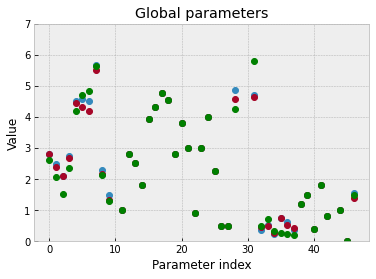

tensor(2.6080) tensor(1.4830) tensor(1.3070)
tensor(2.8137) tensor(1.5538) tensor(1.4928)
tensor(2.8005) tensor(1.3925) tensor(1.3396)


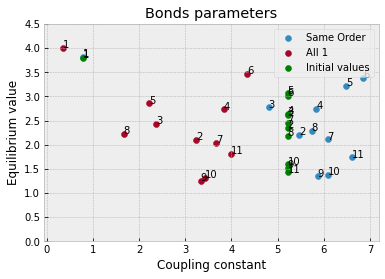

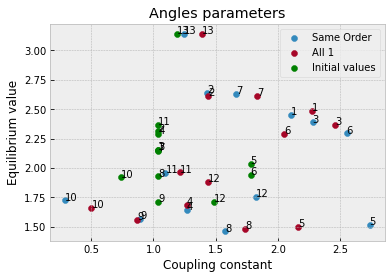

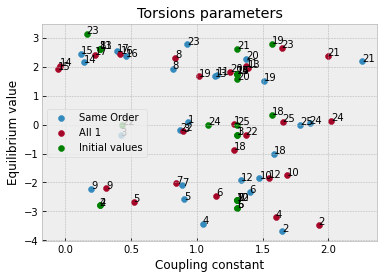

In [67]:
pars_in = [p.data for p in modelin.parameters()]
pars_so = [p.data for p in modelso.parameters()]
pars_1 = [p.data for p in model1.parameters()]

plt.plot(pars_so[0],'o')
plt.plot(pars_1[0],'o')
plt.plot(pars_in[0],'o',c='g')
plt.ylim(0,7)
plt.xlabel('Parameter index')
plt.ylabel('Value')
plt.title('Global parameters')
plt.show()
print(pars_in[0][0], pars_in[0][-1], pars_in[0][9])
print(pars_so[0][0], pars_so[0][-1], pars_so[0][9])
print(pars_1[0][0], pars_1[0][-1], pars_1[0][9])

# x and y coordinates are coupling constant and equilibrium value, respectively

plt.scatter(pars_so[1][:,0]*pars_so[0][0],pars_so[1][:,1],label='Same Order')
plt.scatter(pars_1[1][:,0]*pars_1[0][0],pars_1[1][:,1],label='All 1')
plt.scatter(pars_in[1][:,0]*pars_in[0][0],pars_in[1][:,1],c='g',label='Initial values')
for i in range(len(pars_so[1])):
    plt.annotate(i+1, (pars_so[1][i,0]*pars_so[0][0],pars_so[1][i,1]))
    plt.annotate(i+1, (pars_1[1][i,0]*pars_1[0][0],pars_1[1][i,1]))
    plt.annotate(i+1, (pars_in[1][i,0]*pars_in[0][0],pars_in[1][i,1]))
plt.ylim(0,4.5)
plt.xlabel('Coupling constant')
plt.ylabel('Equilibrium value')
plt.title('Bonds parameters')
plt.legend()
plt.show()

plt.scatter(pars_so[2][:,0]*pars_so[0][-1],pars_so[2][:,1],label='Same Order')
plt.scatter(pars_1[2][:,0]*pars_1[0][-1],pars_1[2][:,1],label='All 1')
plt.scatter(pars_in[2][:,0]*pars_in[0][-1],pars_in[2][:,1],c='g',label='Initial values')
for i in range(len(pars_so[2])):
    plt.annotate(i+1, (pars_so[2][i,0]*pars_so[0][-1],pars_so[2][i,1]))
    plt.annotate(i+1, (pars_1[2][i,0]*pars_1[0][-1],pars_1[2][i,1]))
    plt.annotate(i+1, (pars_in[2][i,0]*pars_in[0][-1],pars_in[2][i,1]))
plt.legend()
plt.xlabel('Coupling constant')
plt.ylabel('Equilibrium value')
plt.title('Angles parameters')
plt.show()

plt.scatter(pars_so[3][:,0]*pars_so[0][9],pars_so[3][:,1],label='Same Order')
plt.scatter(pars_1[3][:,0]*pars_1[0][9],pars_1[3][:,1],label='All 1')
plt.scatter(pars_in[3][:,0]*pars_in[0][9],pars_in[3][:,1],c='g',label='Initial values')
for i in range(len(pars_so[3])):
    plt.annotate(i+1, (pars_so[3][i,0]*pars_so[0][9],pars_so[3][i,1]))
    plt.annotate(i+1, (pars_1[3][i,0]*pars_1[0][9],pars_1[3][i,1]))
    plt.annotate(i+1, (pars_in[3][i,0]*pars_in[0][9],pars_in[3][i,1]))
plt.legend()
plt.xlabel('Coupling constant')
plt.ylabel('Equilibrium value')
plt.title('Torsions parameters')
plt.show()

Bonds energy computed
Angles energy computed
Torsions energy computed


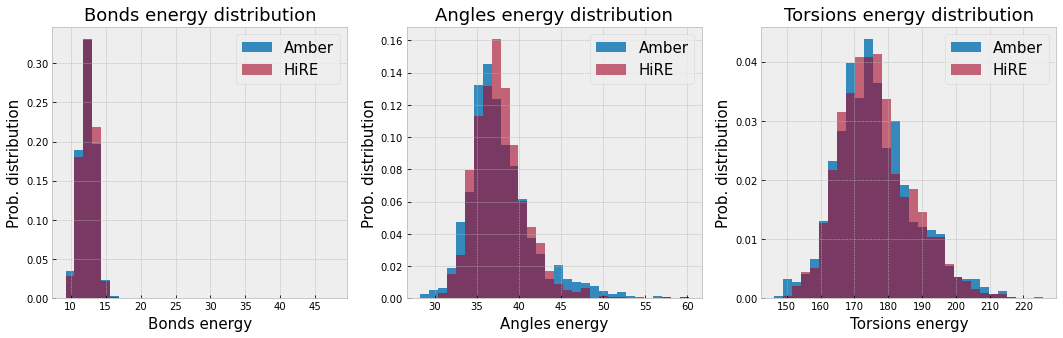

In [9]:
dataset = RNASeqDataset()
en_so, stats_so = compare_energies(dataset,modelso,plot=True)

Bonds energy computed
Angles energy computed
Torsions energy computed


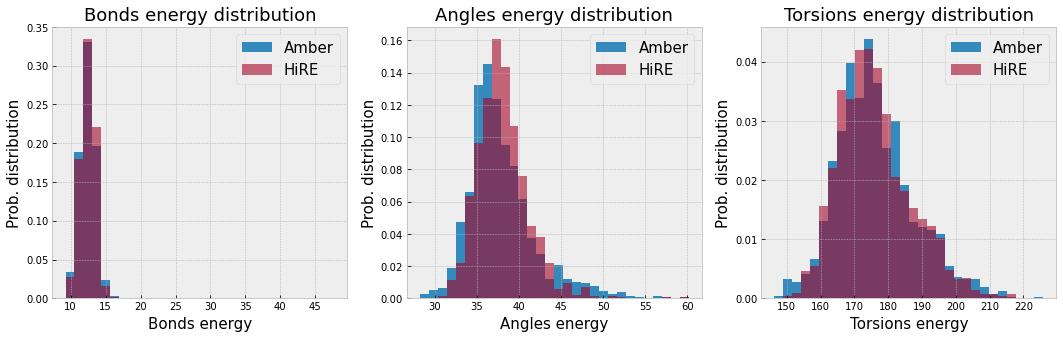

In [10]:
en_1, stats_1 = compare_energies(dataset,model1,plot=True)

In [12]:
print(stats_so)
print(stats_1)

{'amber': array([[ 12.56556257,   3.45207653],
       [ 37.87286557,  15.88671201],
       [176.20829309, 131.22010209]]), 'hire': array([[ 12.51485367,   1.1833793 ],
       [ 37.71728037,   9.35909457],
       [176.42366058, 113.87492059]])}
{'amber': array([[ 12.56556257,   3.45207653],
       [ 37.87286557,  15.88671201],
       [176.20829309, 131.22010209]]), 'hire': array([[ 12.51206972,   1.12939077],
       [ 38.04561459,   9.28025459],
       [176.06701224, 115.11703076]])}


## Small variation of parameters in the same order case

### Modify the dictionary

In [41]:
model = LocalEnergyOpt()
model.load_state_dict(torch.load("data/Results/initial_values_sameorder.pth"))

np.random.seed(42)
sd = model.state_dict()
for p in sd.values():
    for row in p:
        if len(row.shape) == 0:
            row += np.random.uniform(-row/10,row/10)
        else:
            for value in row:
                value += np.random.uniform(-value/10,value/10)
model.load_state_dict(sd)

torch.save(model.state_dict(), 'data/Results/initial_values_sameorder_randomized42.pth')
print(model.state_dict())

OrderedDict([('opt_pars', tensor([  2.5426,   2.2599,   1.5895,   2.4015,   3.9017,   4.3748,   4.3976,   6.0488,   2.1731,   1.3614,  13.7634,
          1.0940,   2.9862,   2.3609,   1.7098,   3.6830,   4.1403,   4.7986,   4.4841,   2.7032,   3.8983,   2.7930,
          0.8703,   2.9198,   3.9649,   2.3857,   0.4512,   0.5014,   4.3255,   9.8349,  11.3602,   5.4356,   0.4574,
          0.7955,   0.3618,   0.2729,   0.2152,   0.1903,   1.2442,   1.4820,   0.3698,   1.7983,   0.7255, 153.9557,
          0.9518,   0.0000,   1.4272])), ('bond_type', tensor([[ 0.3012,  3.8355],
        [ 1.8739,  2.5641],
        [ 2.1101,  2.8525],
        [ 2.1579,  2.6846],
        [ 2.1687,  2.8100],
        [ 1.8784,  2.7308],
        [ 1.9301,  2.3955],
        [ 1.9085,  2.3233],
        [ 1.9427,  1.4534],
        [ 2.0171,  1.4786],
        [ 2.1209,  1.3083],
        [ 0.4390, 12.6534],
        [ 0.0940, 10.8133],
        [ 0.1063, 12.4965],
        [ 0.1046, 12.6510]])), ('angle_type', tensor([[

### After the training

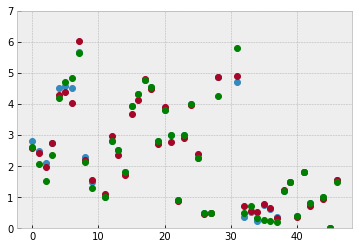

tensor(2.6080) tensor(1.4830) tensor(1.3070)
tensor(2.8137) tensor(1.5538) tensor(1.4928)
tensor(2.5811) tensor(1.5402) tensor(1.5573)


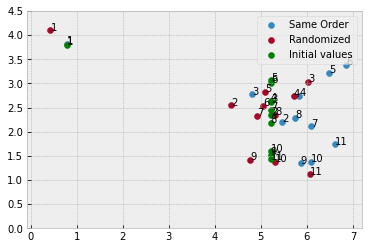

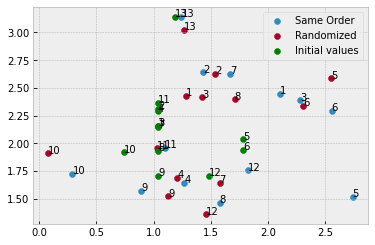

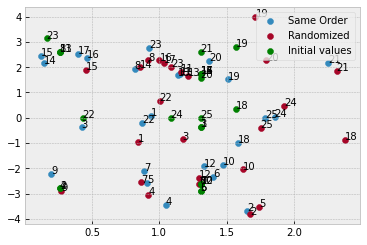

In [62]:
model_so = LocalEnergyOpt()
model_so.load_state_dict(torch.load('data/Results/300_b16_e4_Aso.pth'))
model_rand = LocalEnergyOpt()
model_rand.load_state_dict(torch.load('data/Results/300_b16_e4_Aso_rand42.pth'))
pars_rdm = [p.data for p in model_rand.parameters()]

plt.plot(pars_so[0],'o')
plt.plot(pars_rdm[0],'o')
plt.plot(pars_in[0],'o',c='g')
plt.ylim(0,7)
plt.show()
print(pars_in[0][0], pars_in[0][-1], pars_in[0][9])
print(pars_so[0][0], pars_so[0][-1], pars_so[0][9])
print(pars_rdm[0][0], pars_rdm[0][-1], pars_rdm[0][9])

# x and y coordinates are coupling constant and equilibrium value, respectively

plt.scatter(pars_so[1][:,0]*pars_so[0][0],pars_so[1][:,1],label='Same Order')
plt.scatter(pars_rdm[1][:,0]*pars_rdm[0][0],pars_rdm[1][:,1],label='Randomized')
plt.scatter(pars_in[1][:,0]*pars_in[0][0],pars_in[1][:,1],c='g',label='Initial values')
for i in range(len(pars_so[1])):
    plt.annotate(i+1, (pars_so[1][i,0]*pars_so[0][0],pars_so[1][i,1]))
    plt.annotate(i+1, (pars_rdm[1][i,0]*pars_rdm[0][0],pars_rdm[1][i,1]))
    plt.annotate(i+1, (pars_in[1][i,0]*pars_in[0][0],pars_in[1][i,1]))
plt.ylim(0,4.5)
plt.legend()
plt.show()

plt.scatter(pars_so[2][:,0]*pars_so[0][-1],pars_so[2][:,1],label='Same Order')
plt.scatter(pars_rdm[2][:,0]*pars_rdm[0][-1],pars_rdm[2][:,1],label='Randomized')
plt.scatter(pars_in[2][:,0]*pars_in[0][-1],pars_in[2][:,1],c='g',label='Initial values')
for i in range(len(pars_so[2])):
    plt.annotate(i+1, (pars_so[2][i,0]*pars_so[0][-1],pars_so[2][i,1]))
    plt.annotate(i+1, (pars_rdm[2][i,0]*pars_rdm[0][-1],pars_rdm[2][i,1]))
    plt.annotate(i+1, (pars_in[2][i,0]*pars_in[0][-1],pars_in[2][i,1]))
plt.legend()
plt.show()

plt.scatter(pars_so[3][:,0]*pars_so[0][9],pars_so[3][:,1],label='Same Order')
plt.scatter(pars_rdm[3][:,0]*pars_rdm[0][9],pars_rdm[3][:,1],label='Randomized')
plt.scatter(pars_in[3][:,0]*pars_in[0][9],pars_in[3][:,1],c='g',label='Initial values')
for i in range(len(pars_so[3])):
    plt.annotate(i+1, (pars_so[3][i,0]*pars_so[0][9],pars_so[3][i,1]))
    plt.annotate(i+1, (pars_rdm[3][i,0]*pars_rdm[0][9],pars_rdm[3][i,1]))
    plt.annotate(i+1, (pars_in[3][i,0]*pars_in[0][9],pars_in[3][i,1]))
plt.legend()
plt.show()

Bonds energy computed
Angles energy computed
Torsions energy computed


({'amber': [array([11.33420658, 10.73241138, 14.44979668, ..., 13.21358204,
          11.87942886, 12.29457283]),
   array([35.17036819, 36.43643951, 42.82944107, ..., 38.88216782,
          40.7203064 , 35.08795547]),
   array([186.58657837, 163.8369751 , 190.74627686, ..., 174.96124268,
          160.0533905 , 162.79806519])],
  'hire': [array([11.52023411, 10.60899448, 13.98962879, ..., 12.84313297,
          11.12939739, 12.40841007]),
   array([34.8997345 , 37.86913681, 40.54007721, ..., 38.67460632,
          36.8549881 , 35.45391083]),
   array([176.18843079, 172.88945007, 194.57650757, ..., 179.04698181,
          160.9315033 , 165.04916382])]},
 {'amber': array([[ 12.56556257,   3.45207653],
         [ 37.87286557,  15.88671201],
         [176.20829309, 131.22010209]]),
  'hire': array([[ 12.53868461,   1.21284616],
         [ 37.89183599,   9.97480349],
         [176.14203244, 119.58305865]])})

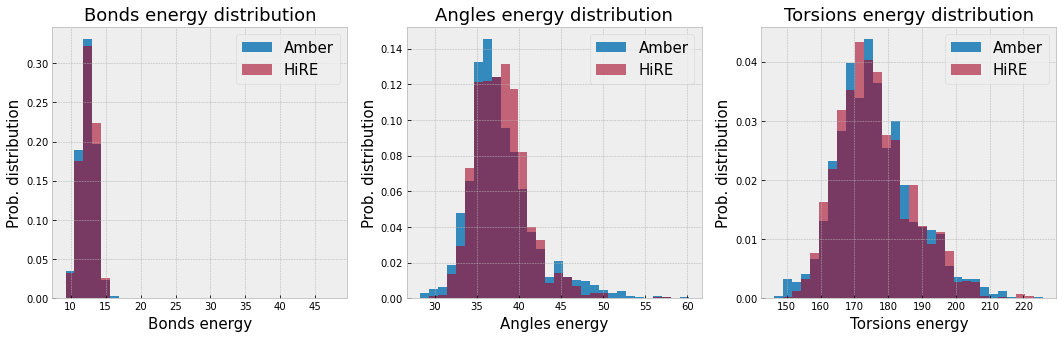

In [63]:
compare_energies(dataset,model_rand,plot=True)

Bonds energy computed
Angles energy computed
Torsions energy computed


({'amber': [array([11.33420658, 10.73241138, 14.44979668, ..., 13.21358204,
          11.87942886, 12.29457283]),
   array([35.17036819, 36.43643951, 42.82944107, ..., 38.88216782,
          40.7203064 , 35.08795547]),
   array([186.58657837, 163.8369751 , 190.74627686, ..., 174.96124268,
          160.0533905 , 162.79806519])],
  'hire': [array([11.63786983, 10.69278049, 14.9247303 , ..., 13.41615486,
          11.88383389, 12.40886974]),
   array([37.14387131, 36.15362167, 40.74763107, ..., 36.18569946,
          35.34510803, 36.18568039]),
   array([172.48031616, 169.01808167, 190.99783325, ..., 179.28952026,
          159.65515137, 165.60049438])]},
 {'amber': array([[ 12.56556257,   3.45207653],
         [ 37.87286557,  15.88671201],
         [176.20829309, 131.22010209]]),
  'hire': array([[ 12.49669018,   1.22882703],
         [ 37.84092603,   8.68969867],
         [176.21398082, 120.55569252]])})

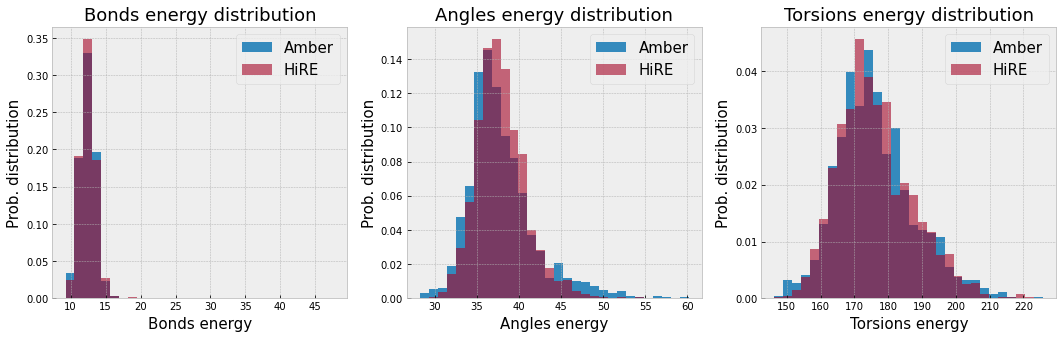

In [64]:
compare_energies(dataset,model_so,plot=True)